In [48]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import Dataset, dataloader
from torchvision import datasets
import random
import scipy.io as sio
from PIL import Image
from pathlib import Path
from torch import optim 

In [49]:
# Data is already split

train_dir = Path('C:/Users/matthew.hui/Documents/code2/archive/train')
test_dir = Path('C:/Users/matthew.hui/Documents/code2/archive/test')
val_dir = Path('C:/Users/matthew.hui/Documents/code2/archive/val')

In [50]:
from torchvision import transforms

transformer = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [51]:
trainfolder = datasets.ImageFolder(train_dir, transform=transformer)
testfolder = datasets.ImageFolder(test_dir, transform=transformer)
valfolder = datasets.ImageFolder(val_dir, transform=transformer)

classes = trainfolder.classes

In [52]:
import torch.utils.data as data    

BATCH_SIZE = 32

train_set_loader = data.DataLoader(trainfolder, batch_size=BATCH_SIZE, shuffle=True)
test_set_loader = data.DataLoader(testfolder, batch_size=BATCH_SIZE, shuffle=True)
val_set_loader = data.DataLoader(valfolder, batch_size=BATCH_SIZE, shuffle=True)

train_set_loader

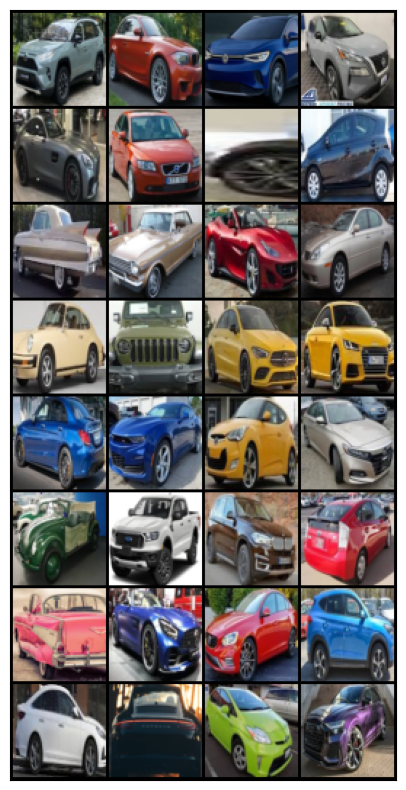

In [53]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

for images, labels in train_set_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4).permute(1,2,0))
    break



In [54]:
# Define model

class NET(nn.Module):
    def __init__(self):
        super(NET, self).__init__()

        # first layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        # Second layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        # Third layer
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.25)
        )

        self.fc = nn.Sequential(
            nn.Linear(512, int(len(classes)))
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        x = x.view(x.size(0), -1)

        return self.fc(x)

In [55]:
model = NET()
model

NET(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.25, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p

In [56]:
# LEARNING_RATE = 0.01
# lossFunc = nn.CrossEntropyLoss()
# optimizer = optim.Adamax(model.parameters(), lr=LEARNING_RATE)

In [57]:
# import numpy as np

# epochs = 40
# valid_loss_min = np.Inf
# train_losses, valid_losses = [], []
# history_accuracy = []

# for e in range(1, epochs+1):
#     running_loss = 0
#     for images, labels in train_set_loader:
#         # if train_on_gpu:
#         #     images, labels = images.cuda(), labels.cuda()
#         # Clear the gradients, do this because gradients are accumulated.
#         optimizer.zero_grad()

#         # Forward pass, get our log-probabilities.
#         ps = model(images)
        
#         # Calculate the loss with the logps and the labels.
#         loss = lossFunc(ps, labels)

#         # Turning loss back.
#         loss.backward()

#         # Take an update step and few the new weights.
#         optimizer.step()
#         running_loss += loss.item()
#         # scheduler.step()
#     else:
#         valid_loss = 0
#         accuracy = 0
#         # Turn off gradients for validation, saves memory and computations.

#         with torch.no_grad():
#             model.eval() # change the network to evaluation mode
#             for images, labels in val_set_loader:
#                 # if train_on_gpu:
#                 #     images, labels = images.cuda(), labels.cuda()

#                 # Forward pass, get our log-probabilities.

#                 #log_ps = model(images)
#                 ps = model(images)
#                 # Calculating probabilities for each class.

#                 #ps = torch.exp(log_ps)
#                 # Capturing the class more likely.
#                 _, top_class = ps.topk(1, dim=1)
               
#                 # Verifying the prediction with the labels provided.
#                 equals = top_class == labels.view(*top_class.shape)
#                 valid_loss += lossFunc(ps, labels)
#                 accuracy += torch.mean(equals.type(torch.FloatTensor))

#         model.train() # change the network to training mode
#         train_losses.append(running_loss/len(train_set_loader))
#         valid_losses.append(valid_loss/len(val_set_loader))
#         history_accuracy.append(accuracy/len(val_set_loader))
#         network_learned = valid_loss < valid_loss_min

#         if e == 1 or e % 5 == 0 or network_learned:
#             print(f"Epoch: {e}/{epochs}.. ",
#                   f"Training Loss: {running_loss/len(train_set_loader):.3f}.. ",
#                   f"Validation Loss: {valid_loss/len(val_set_loader):.3f}.. ",
#                   f"Test Accuracy: {accuracy/len(val_set_loader):.3f}")
            
#         if network_learned:
#             valid_loss_min = valid_loss
#             torch.save(model.state_dict(), 'car_model.pt')
#             print('Detected network improvement, saving current model')

In [58]:
# Testing block
# model = model()
model.load_state_dict(torch.load("car_model.pt"))
model.eval()

y_pred = []
y_true = []

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_set_loader:
        images, labels = data
        # print(np.shape(images))
        # calculate outputs by running images through the network
        outputs = model(images)

        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        y_pred.extend(predicted) # Save Prediction

        y_true.extend(labels) # Save Truth

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the unseen test images: {100 * correct // total} %')


#try training with one rgb channel 
#load model and test with image not in dataset
#live plot or just plot loss and validation loss and accuracy
#use efficient net0b w/ transfer learning
#try transfer learning
#do research into good models
#try changing kernel size in conv2d layers
#confusion matrix to find problems between classes
#pretrained model / transfer learning
#120 : 180
#visualize neural network
#show different models
#get rid of other class'
#double data with horizontal flipping
#***per-pixel mean subtracted***

#object tracking with cars 

Accuracy of the network on the unseen test images: 81 %


In [60]:
# Demonstrate capability
import torch

transformer2 = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NET()
model = torch.load('car_model.pt')
# model.eval()

In [62]:
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

def predict_image(image):
    image_tensor = transformer2(image).float()
    image_tensor = image_tensor[np.newaxis, ...]
    # input = Variable(image_tensor)
    # input = input.to(device)
    output = model(image_tensor)
    # index = output.data.cpu().numpy().argmax()
    _, predictions = torch.max(output, dim = 1)
    return predictions


    

def get_random_images(num, dir):
    data = datasets.ImageFolder(dir, transform=transformer2) # Create image folder
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    sampler = SubsetRandomSampler(idx)
    loader = DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = next(dataiter)
    return images, labels

test_dir = Path('C:/Users/matthew.hui/Documents/code2/archive/test')

to_pil = transforms.ToPILImage()
images, labels = get_random_images(5, test_dir)

# display results
fig = plt.figure(figsize=(10, 10))
for i in range(len(images)):
    image = to_pil(images[i])
    index = predict_image(image)
    subplt = fig.add_subplot(1, len(images), i+1) 
    result = int(labels[i]) == index
    subplt.set_title("Predicted: " + str(classes[index]))
    plt.axis('off')
    plt.imshow(image)
plt.show()

TypeError: 'collections.OrderedDict' object is not callable

<Figure size 1000x1000 with 0 Axes>